In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import webbrowser
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
from IPython.display import display

In [2]:
global filename, svm_cls, rf_cls, xg_cls
global X,Y
global dataset
global accuracy, precision, recall, fscore, vector
global X_train, X_test, y_train, y_test, scaler
global labels
columns = ['proto', 'service', 'state', 'attack_cat']
label_encoder = []

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


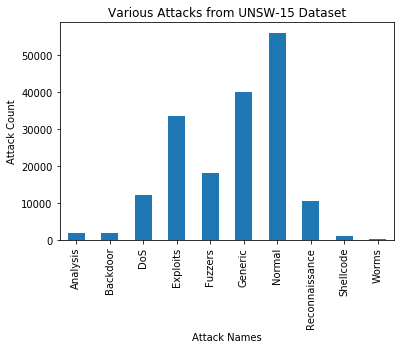

In [3]:
def uploadDataset():
    global filename, dataset, labels
    filename = "Dataset/UNSW_NB.csv" #upload dataset file
    dataset = pd.read_csv(filename) #read dataset from uploaded file
    labels = np.unique(dataset['attack_cat'])
    display(dataset)
    
    label = dataset.groupby('attack_cat').size()
    label.plot(kind="bar")
    plt.xlabel('Attack Names')
    plt.ylabel('Attack Count')
    plt.xticks(rotation=90)
    plt.title("Various Attacks from UNSW-15 Dataset")
    plt.show()
uploadDataset()    

In [4]:
def preprocessing():
    global dataset, scaler
    global X_train, X_test, y_train, y_test, X, Y
    #replace missing values with 0
    dataset.fillna(0, inplace = True)
    dataset.drop(['label'], axis = 1,inplace=True)
    for i in range(len(columns)):
        le = LabelEncoder()
        dataset[columns[i]] = pd.Series(le.fit_transform(dataset[columns[i]].astype(str))) #encoding non-numeric labels into numeric
        label_encoder.append(le)
    dataset = dataset.values
    X = dataset[:,0:dataset.shape[1]-1]
    Y = dataset[:,dataset.shape[1]-1]
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices) #shuffle dataset
    X = X[indices]
    Y = Y[indices]
    X = normalize(X) #data normalizing
    print()
    print("Dataset after features normalization")
    print(str(X)+"\n")
    print("Total records found in dataset : "+str(X.shape[0]))
    print("Total features found in dataset: "+str(X.shape[1]))
    print()
preprocessing()    


Dataset after features normalization
[[1.82997918e-05 4.60369398e-10 3.87533071e-08 ... 1.02884886e-09
  6.85899241e-10 0.00000000e+00]
 [2.56944600e-03 1.77630575e-13 2.34867093e-06 ... 3.55261150e-07
  4.34208072e-07 0.00000000e+00]
 [2.24398895e-03 1.40350186e-13 2.08770902e-06 ... 5.96488292e-07
  5.96488292e-07 0.00000000e+00]
 ...
 [1.44715735e-03 7.99998537e-14 1.19999781e-06 ... 2.99999451e-08
  5.99998903e-08 0.00000000e+00]
 [3.88498092e-05 8.08024109e-10 7.90725416e-08 ... 1.39951401e-09
  6.99757005e-10 0.00000000e+00]
 [2.36036808e-05 8.43259704e-10 6.05085285e-08 ... 5.35473703e-10
  1.07094741e-09 0.00000000e+00]]

Total records found in dataset : 175341
Total features found in dataset: 43



In [5]:
def dataSplit():
    global X_train, X_test, y_train, y_test, X, Y
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split data into train & test
    print()
    print("Dataset Train and Test Split\n")
    print("80% dataset records used to train ML algorithms : "+str(X_train.shape[0]))
    print("20% dataset records used to train ML algorithms : "+str(X_test.shape[0])+"\n")
    X = np.load("model/X.npy")
    Y = np.load("model/Y.npy")
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)    
dataSplit()    


Dataset Train and Test Split

80% dataset records used to train ML algorithms : 140272
20% dataset records used to train ML algorithms : 35069



In [6]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print()
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))
    print()

    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

C:\Users\Ramya\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



SVM Algorithm Accuracy  :  23.440860215053764
SVM Algorithm Precision : 15.968923681251779
SVM Algorithm Recall    : 23.90549072649062
SVM Algorithm FScore    : 14.66156115334952



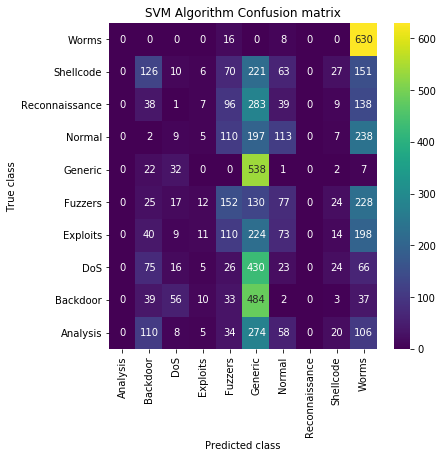

In [7]:
def runSVM():
    global X_train, X_test, y_train, y_test, X, Y
    global svm_cls
    global accuracy, precision, recall, fscore
    accuracy = []
    precision = []
    recall = []
    fscore = []
    if os.path.exists('model/svm.txt'):
        with open('model/svm.txt', 'rb') as file:
            svm_cls = pickle.load(file)
        file.close()        
    else:
        svm_cls = SVC()
        svm_cls.fit(X_train,y_train)
        with open('model/svm.txt', 'wb') as file:
            pickle.dump(svm_cls, file)
        file.close()
    predict = svm_cls.predict(X_test)
    calculateMetrics("SVM Algorithm", predict, y_test)
runSVM()    


Random Forest Algorithm Accuracy  :  97.81874039938556
Random Forest Algorithm Precision : 97.840461369244
Random Forest Algorithm Recall    : 97.83588829783305
Random Forest Algorithm FScore    : 97.83448601587017



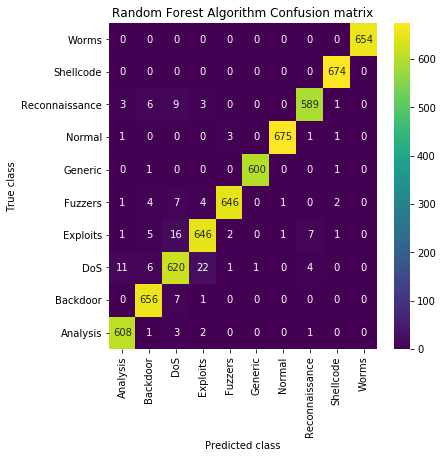

In [8]:
def runRandomForest():
    global X_train, X_test, y_train, y_test, X, Y
    global rf_cls
    if os.path.exists('model/rf.txt'):
        with open('model/rf.txt', 'rb') as file:
            rf_cls = pickle.load(file)
        file.close()        
    else:
        rf_cls = RandomForestClassifier()
        rf_cls.fit(X_train,y_train)
        with open('model/rf.txt', 'wb') as file:
            pickle.dump(rf_cls, file)
        file.close()
    predict = rf_cls.predict(X_test)
    calculateMetrics("Random Forest Algorithm", predict, y_test)
runRandomForest()    


XGBoost Algorithm Accuracy  :  99.23195084485407
XGBoost Algorithm Precision : 99.23877612940328
XGBoost Algorithm Recall    : 99.24244962637137
XGBoost Algorithm FScore    : 99.24006463038388



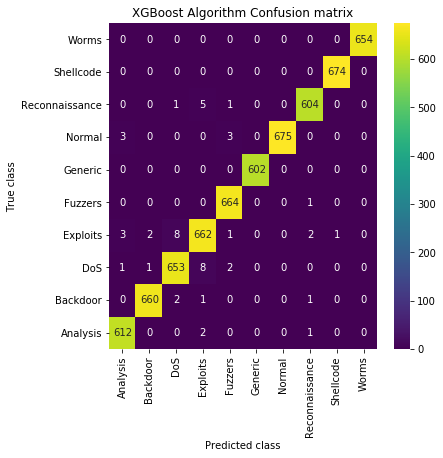

In [9]:
def runXGBoost():
    global X_train, X_test, y_train, y_test, X, Y
    global xg_cls
    if os.path.exists('model/xg.txt'):
        with open('model/xg.txt', 'rb') as file:
            xg_cls = pickle.load(file)
        file.close()        
    else:
        xg_cls = RandomForestClassifier()
        xg_cls.fit(X_train,y_train)
        with open('model/xg.txt', 'wb') as file:
            pickle.dump(xg_cls, file)
        file.close()
    predict = xg_cls.predict(X_test)
    calculateMetrics("XGBoost Algorithm", predict, y_test)
runXGBoost()    

In [10]:
def attackPrediction():
    global xg_cls, label_encoder, labels
    filename = "Dataset/testData.csv"
    dataset = pd.read_csv(filename)
    dataset.fillna(0, inplace = True)
    for i in range(len(columns)-1):
        dataset[columns[i]] = pd.Series(label_encoder[i].fit_transform(dataset[columns[i]].astype(str)))
    dataset = dataset.values
    X = dataset
    predict = xg_cls.predict(X)  #prediction on test data
    for i in range(len(predict)):
        print("Test Data : "+str(dataset[i])+" ====> Predicted As : "+labels[i]+"\n")
attackPrediction()        

Test Data : [8.80000000e+01 1.00000000e-05 4.00000000e+00 0.00000000e+00
 2.00000000e+00 2.00000000e+00 0.00000000e+00 1.44800000e+03
 0.00000000e+00 1.00000003e+05 2.54000000e+02 0.00000000e+00
 5.79200000e+08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.24000000e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30000000e+01
 2.00000000e+00 5.00000000e+00 5.00000000e+00 1.00000000e+00
 4.00000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.00000000e+00 3.90000000e+01 0.00000000e+00] ====> Predicted As : Analysis

Test Data : [5.76970000e+04 3.00000000e-06 2.00000000e+00 0.00000000e+00
 2.00000000e+00 2.00000000e+00 0.00000000e+00 2.00000000e+02
 0.00000000e+00 3.33333322e+05 2.54000000e+02 0.00000000e+00
 2.66666656e+08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.00000000e-03 0.00000000e+00 0.00000000e+0

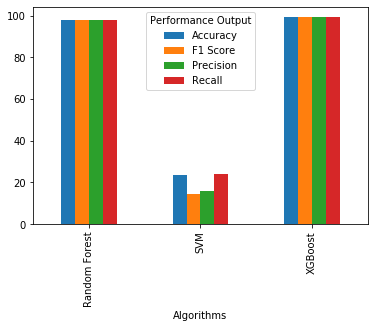

In [11]:
def graph():
    output = "<html><body><table align=center border=1><tr><th>Algorithm Name</th><th>Accuracy</th><th>Precision</th><th>Recall</th>"
    output+="<th>FSCORE</th></tr>"
    output+="<tr><td>SVM</td><td>"+str(accuracy[0])+"</td><td>"+str(precision[0])+"</td><td>"+str(recall[0])+"</td><td>"+str(fscore[0])+"</td></tr>"
    output+="<tr><td>Random Forest</td><td>"+str(accuracy[1])+"</td><td>"+str(precision[1])+"</td><td>"+str(recall[1])+"</td><td>"+str(fscore[1])+"</td></tr>"
    output+="<tr><td>XGBoost</td><td>"+str(accuracy[2])+"</td><td>"+str(precision[2])+"</td><td>"+str(recall[2])+"</td><td>"+str(fscore[2])+"</td></tr>"
    output+="</table></body></html>"
    f = open("table.html", "w")
    f.write(output)
    f.close()
    webbrowser.open("table.html",new=2)
    df = pd.DataFrame([['SVM','Precision',precision[0]],['SVM','Recall',recall[0]],['SVM','F1 Score',fscore[0]],['SVM','Accuracy',accuracy[0]],
                       ['Random Forest','Precision',precision[1]],['Random Forest','Recall',recall[1]],['Random Forest','F1 Score',fscore[1]],['Random Forest','Accuracy',accuracy[1]],
                       ['XGBoost','Precision',precision[2]],['XGBoost','Recall',recall[2]],['XGBoost','F1 Score',fscore[2]],['XGBoost','Accuracy',accuracy[2]],
                      ],columns=['Algorithms','Performance Output','Value'])
    df.pivot("Algorithms", "Performance Output", "Value").plot(kind='bar')
    plt.show()
graph()    